## Baseline - Biased_Margin

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module
Random State가  1  일 때  Basic model:  0.6634499367038532
Split_ratio:  0.2 이고 Random State가  1  일 때  Baseline model split ratio 0.2:  0.660307381913126
Random State가  1  일 때  Advance model:  0.7380899398686604
Random State가  2  일 때  Basic model:  0.6484789144710816
Split_ratio:  0.2 이고 Random State가  2  일 때  Baseline model split ratio 0.2:  0.636776544821584
Random State가  2  일 때  Advance model:  0.7698220784872221
Random State가  3  일 때  Basic model:  0.6999836814621411
Split_ratio:  0.2 이고 Random State가  3  일 때  Baseline model split ratio 0.2:  0.697397440462062
Random State가  3  일 때  Advance model:  0.7424415499643958
Random State가  4  일 때  Basic model:  0.5663793615001187
Split_ratio:  0.2 이고 Random State가  4  일 때  Baseline model split ratio 0.2:  0.6508104873803308
Random State가  4  일 때  Advance model:  0.7040237558351136
Random State가  5  일 때  Basic model:  0.7319877957116862
Split_ratio:  0.2 이고 Random State가  5  일 때  Bas

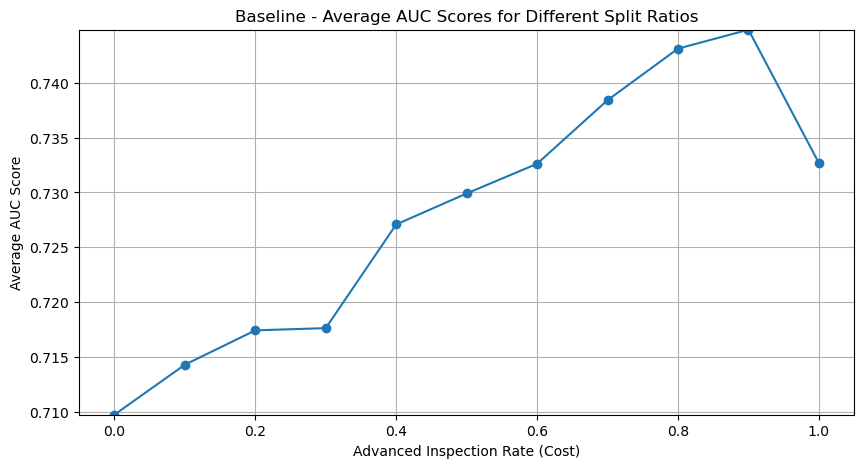

In [23]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader



# 설치된 모듈 경로로 이동하기
%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기
from split_and_predict_uncertainty import split_and_predict_uncertainty
from seed_everything import seed_everything
from train_teacher import train_teacher
from train_student import train_student
from train_kdstudent import train_kdstudent
from test_predict import test_predict

#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#


# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_Baseline_biased_margin = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

mat_file = io.loadmat('/home/iai/heo/recipe1/activeinspection_recipe1.mat')
X = mat_file['X']
X = X[:, 4:]
Y = mat_file['Y1']
Y = np.squeeze(Y)
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})


# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


### class weight 초기화

a=87/(18384+87)
b=18384/(18384+87)
weights=[a,b]
weights=torch.FloatTensor(weights)

# loss function - crossentropy()함수
    
criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_Baseline=[]
auc_score30_split_Baseline_0_2=[]
auc_score30_split_ad_BL=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=3694
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    # optimizer 정의
    teacher_model = Teacher()
    student_model = Student()
    optimizer_advance = optim.Adam(teacher_model.parameters(), lr=learning_rate)
    optimizer_basic = optim.Adam(student_model.parameters(), lr=learning_rate)
    
    # Teacher model (advanced model 구하기)    
    
    best_teacher_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/advance_model_recipe1/advancemodel_randomstate{}'.format(i))  

    best_student_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/basic_model_recipe1/basicmodel_randomstate{}'.format(i))
            
 

    # 테스트 데이터의 입력(X)와 라벨(y)을 결합

    test_data=pd.concat([test_X,test_y],axis=1)

    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)
    

# training 데이터에서 고장난 제품의 비율(Fault Ratio) 계산
    fr = np.sum(test_y) / len(test_y)

# Biased margin을 계산하여 uncertainty score로 사용
    def calculate_biased_margin(y_pred, fr):
        if y_pred <= fr:
            return y_pred / fr
        else:
            return (1 - y_pred) / (1 - fr)

# 각각의 예측에 대해 biased margin을 계산
    uncertainty_scores = [calculate_biased_margin(y_pred, fr.item()) for y_pred in y_predictions]
    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_Baseline_biased_margin[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_Baseline.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "Basic model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_Baseline_0_2.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "Baseline model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_BL.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_Baseline_biased_margin = auc_scores_Baseline_biased_margin.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_Baseline_biased_margin, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_Baseline_biased_margin), max(average_auc_scores_Baseline_biased_margin))
plt.grid()
plt.show()   



In [24]:
average_auc_scores_Baseline_biased_margin

array([0.70972012, 0.71428078, 0.71741786, 0.7176218 , 0.7270835 ,
       0.72990965, 0.73262228, 0.73842538, 0.74312709, 0.74485138,
       0.73267692])

In [25]:

# Baseline 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_Baseline)))

# Baseline 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_ad_BL)))


0.7097201205923465
0.04851814551011683


## Biased_Margin - Knowledge distillation (T=1)

/home/iai/heo/recipe1_total_25_new/pytorch_module
Random State가  1  일 때  T가 1일 때 model:  0.7153923372102223
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.7162725492523142
Random State가  1  일 때  Advance model:  0.7380899398686604
Random State가  2  일 때  T가 1일 때 model:  0.7310334084975078
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.7226367790173274
Random State가  2  일 때  Advance model:  0.7698220784872221
Random State가  3  일 때  T가 1일 때 model:  0.7334416290845794
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.7356347416726007
Random State가  3  일 때  Advance model:  0.7424415499643959
Random State가  4  일 때  T가 1일 때 model:  0.6243794010602104
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.6537082641031727
Random State가  4  일 때  Advance model:  0.7040237558351136
Random State가  5  일 때  T가 1일 때 model:  0.7404289302951181
Split_ratio:  0.2 이고 Random State가  5  일 때  model split ratio 0.2:  0.7114758881

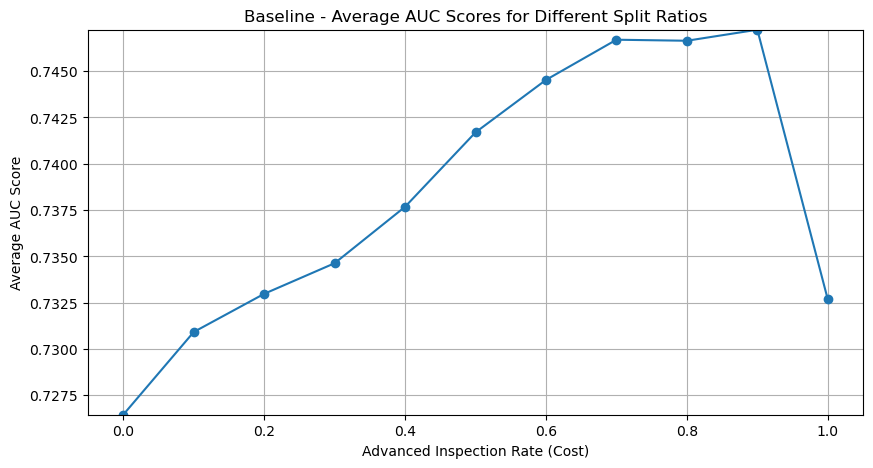

In [4]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader



# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_25_new/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_uncertainty import split_and_predict_uncertainty
from seed_everything import seed_everything
from train_teacher import train_teacher
from train_student import train_student
from test_predict import test_predict

#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#


# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_KD_biased_margin_t1 = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

mat_file = io.loadmat('/home/iai/heo/recipe1/activeinspection_recipe1.mat')
X = mat_file['X']
X = X[:, 4:]
Y = mat_file['Y1']
Y = np.squeeze(Y)
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})


# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


### 클래스 weight 설정하기

a=87/(18384+87)
b=18384/(18384+87)
weights=[a,b]
weights=torch.FloatTensor(weights)



# loss function - crossentropy()함수

criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_KD_t1=[]
auc_score30_split_KD_0_2_t1=[]
auc_score30_split_ad_KD_t1=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=3694
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    
    # Teacher model (advanced model 구하기)    
    
    best_teacher_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/advance_model_recipe1/advancemodel_randomstate{}'.format(i))  

    best_student_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/temperature1_kd_model_recipe1/temperature1_kd_basicmodel_randomstate{}'.format(i))
            

    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    test_data=pd.concat([test_X,test_y],axis=1)
    # 예측값을 numpy 배열로 변환    
   
    

# training 데이터에서 고장난 제품의 비율(Fault Ratio) 계산
    fr = np.sum(test_y) / len(test_y)

# Biased margin을 계산하여 uncertainty score로 사용
    def calculate_biased_margin(y_pred, fr):
        if y_pred <= fr:
            return y_pred / fr
        else:
            return (1 - y_pred) / (1 - fr)

# 각각의 예측에 대해 biased margin을 계산
    uncertainty_scores = [calculate_biased_margin(y_pred, fr.item()) for y_pred in y_predictions]
    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_KD_biased_margin_t1[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t1.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T가 1일 때 model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t1.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t1.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_KD_biased_margin_t1 = auc_scores_KD_biased_margin_t1.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_biased_margin_t1, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_biased_margin_t1), max(average_auc_scores_KD_biased_margin_t1))
plt.grid()
plt.show()   


In [5]:
average_auc_scores_KD_biased_margin_t1

array([0.72645548, 0.73091996, 0.73298108, 0.73463329, 0.7376793 ,
       0.74169683, 0.7445281 , 0.74669735, 0.74664164, 0.74723689,
       0.73267692])

## Biased_Margin - Knowledge distillation (T=2)

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module
Random State가  1  일 때  T=2일 때 KD model:  0.7704105348524409
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.77021520689928


Random State가  1  일 때  Advance model:  0.7380899398686604
Random State가  2  일 때  T=2일 때 KD model:  0.6579881715325578
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.6591972268375663
Random State가  2  일 때  Advance model:  0.7698220784872221
Random State가  3  일 때  T=2일 때 KD model:  0.6763650704169634
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.6767853963921197
Random State가  3  일 때  Advance model:  0.7424415499643958
Random State가  4  일 때  T=2일 때 KD model:  0.7013485046285307
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.7012372418704012
Random State가  4  일 때  Advance model:  0.7040237558351136
Random State가  5  일 때  T=2일 때 KD model:  0.7397564087348684
Split_ratio:  0.2 이고 Random State가  5  일 때  model split ratio 0.2:  0.7411954070733444
Random State가  5  일 때  Advance model:  0.7145417952369649
Random State가  6  일 때  T=2일 때 KD model:  0.7881730160613972
Split_ratio:  0.2 이고 Random State가  6  일 때  model split ratio 

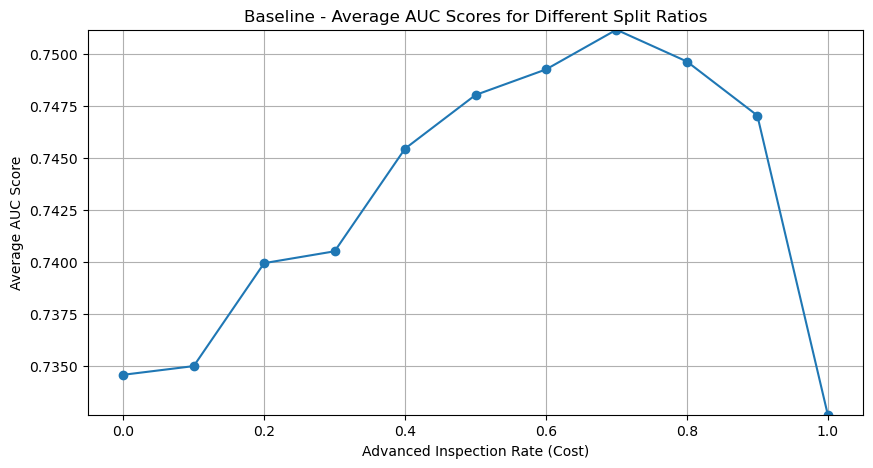

In [26]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader



# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

### 모듈 함수 불러오기

from split_and_predict_uncertainty import split_and_predict_uncertainty
from seed_everything import seed_everything
from test_predict import test_predict

#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#


# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_KD_biased_margin_t2 = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

mat_file = io.loadmat('/home/iai/heo/recipe1/activeinspection_recipe1.mat')
X = mat_file['X']
X = X[:, 4:]
Y = mat_file['Y1']
Y = np.squeeze(Y)
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})


# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


### 클래스 weight 설정하기

a=87/(18384+87)
b=18384/(18384+87)
weights=[a,b]
weights=torch.FloatTensor(weights)



# loss function - crossentropy()함수

criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_KD_t2=[]
auc_score30_split_KD_0_2_t2=[]
auc_score30_split_ad_KD_t2=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=3694
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    
    # Teacher model (advanced model 구하기)    
    
    best_teacher_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/advance_model_recipe1/advancemodel_randomstate{}'.format(i))  

    best_student_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/temperature2_kd_model_recipe1/temperature2_kd_basicmodel_randomstate{}'.format(i))
            

    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    test_data=pd.concat([test_X,test_y],axis=1)
    # 예측값을 numpy 배열로 변환    
   
    

# training 데이터에서 고장난 제품의 비율(Fault Ratio) 계산
    fr = np.sum(test_y) / len(test_y)

# Biased margin을 계산하여 uncertainty score로 사용
    def calculate_biased_margin(y_pred, fr):
        if y_pred <= fr:
            return y_pred / fr
        else:
            return (1 - y_pred) / (1 - fr)

# 각각의 예측에 대해 biased margin을 계산
    uncertainty_scores = [calculate_biased_margin(y_pred, fr.item()) for y_pred in y_predictions]
    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_KD_biased_margin_t2[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t2.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T=2일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t2.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t2.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_KD_biased_margin_t2 = auc_scores_KD_biased_margin_t2.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_biased_margin_t2, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_biased_margin_t2), max(average_auc_scores_KD_biased_margin_t2))
plt.grid()
plt.show()   

In [27]:
average_auc_scores_KD_biased_margin_t2

array([0.73459398, 0.73501113, 0.73995285, 0.74052148, 0.74544989,
       0.74802455, 0.74925079, 0.75115684, 0.74963106, 0.74703852,
       0.73267688])

In [28]:
# T가 2일 때 KD 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_KD_t2)))

# KD 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_KD_t2)))

0.7345939815913706
0.05274611139161144


## Biased_Margin - Knowledge distillation (T=5)

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module
Random State가  1  일 때  T=5일 때 KD model:  0.7750192855447425
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.7744209391565787
Random State가  1  일 때  Advance model:  0.7380899398686606
Random State가  2  일 때  T=5일 때 KD model:  0.6580845992562703
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.6590538215048659
Random State가  2  일 때  Advance model:  0.7698220784872221
Random State가  3  일 때  T=5일 때 KD model:  0.6764478993591264
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.6767915776564601
Random State가  3  일 때  Advance model:  0.7424415499643959
Random State가  4  일 때  T=5일 때 KD model:  0.7027553603924361
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.7016872379143919
Random State가  4  일 때  Advance model:  0.7040237558351136
Random State가  5  일 때  T=5일 때 KD model:  0.7412374396708601
Split_ratio:  0.2 이고 Random State가  5  일 때  model split rati

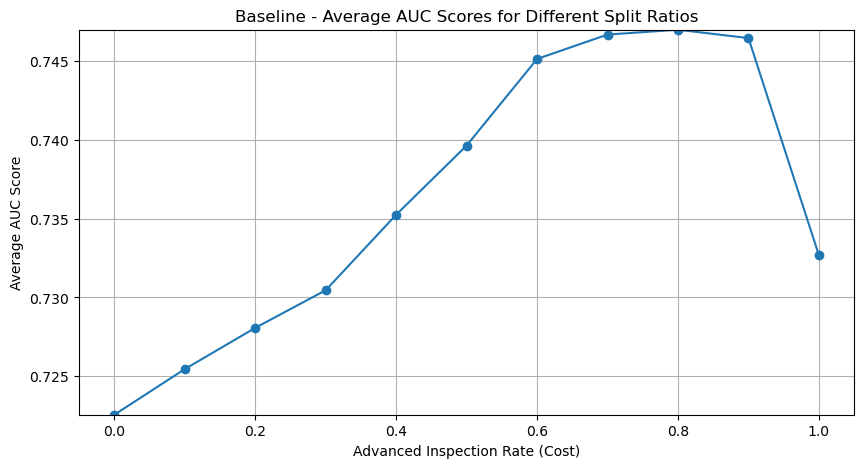

In [29]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader



# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_uncertainty import split_and_predict_uncertainty
from seed_everything import seed_everything

from test_predict import test_predict

#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#
## 난수 지정하기

seed_everything(42)

# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_KD_biased_margin_t5 = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

mat_file = io.loadmat('/home/iai/heo/recipe1/activeinspection_recipe1.mat')
X = mat_file['X']
X = X[:, 4:]
Y = mat_file['Y1']
Y = np.squeeze(Y)
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})


# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


### class weight 초기화

a=87/(18384+87)
b=18384/(18384+87)
weights=[a,b]
weights=torch.FloatTensor(weights)

# loss function - crossentropy()함수
    
criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_KD_t5=[]
auc_score30_split_KD_0_2_t5=[]
auc_score30_split_ad_KD_t5=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=3694
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    
    # Teacher model (advanced model 구하기)    
    
    best_teacher_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/advance_model_recipe1/advancemodel_randomstate{}'.format(i)) 

    best_student_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/temperature5_kd_model_recipe1/temperature5_kd_basicmodel_randomstate{}'.format(i))
            

    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    test_data=pd.concat([test_X,test_y],axis=1)
    # 예측값을 numpy 배열로 변환    
   
    

# training 데이터에서 고장난 제품의 비율(Fault Ratio) 계산
    fr = np.sum(test_y) / len(test_y)

# Biased margin을 계산하여 uncertainty score로 사용
    def calculate_biased_margin(y_pred, fr):
        if y_pred <= fr:
            return y_pred / fr
        else:
            return (1 - y_pred) / (1 - fr)

# 각각의 예측에 대해 biased margin을 계산
    uncertainty_scores = [calculate_biased_margin(y_pred, fr.item()) for y_pred in y_predictions]
    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_KD_biased_margin_t5[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t5.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T=5일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t5.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t5.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_KD_biased_margin_t5 = auc_scores_KD_biased_margin_t5.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_biased_margin_t5, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_biased_margin_t5), max(average_auc_scores_KD_biased_margin_t5))
plt.grid()
plt.show()   

In [30]:
average_auc_scores_KD_biased_margin_t5

array([0.72254765, 0.72544843, 0.72806859, 0.73045876, 0.73525546,
       0.73965149, 0.74515282, 0.74670048, 0.74700839, 0.74647684,
       0.73267688])

In [31]:
# T가 5일 때 KD 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_KD_t5)))

# KD 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_KD_t5)))

0.7225476451855367
0.06135419722706725


## Biased_Margin - Knowledge distillation (T=10)

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module
Random State가  1  일 때  T=10일 때 KD model:  0.7731797412769997
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.772405846981565


Random State가  1  일 때  Advance model:  0.7380899398686604
Random State가  2  일 때  T=10일 때 KD model:  0.6579313039006252
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.6587917358968274
Random State가  2  일 때  Advance model:  0.7698220784872222
Random State가  3  일 때  T=10일 때 KD model:  0.6791008980140834
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.679316006013134
Random State가  3  일 때  Advance model:  0.7424415499643959
Random State가  4  일 때  T=10일 때 KD model:  0.7047655075559776
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.7049014953714693
Random State가  4  일 때  Advance model:  0.7040237558351136
Random State가  5  일 때  T=10일 때 KD model:  0.5894700925706148
Split_ratio:  0.2 이고 Random State가  5  일 때  model split ratio 0.2:  0.6077666350185933
Random State가  5  일 때  Advance model:  0.7145417952369649
Random State가  6  일 때  T=10일 때 KD model:  0.7879059854418862
Split_ratio:  0.2 이고 Random State가  6  일 때  model split ra

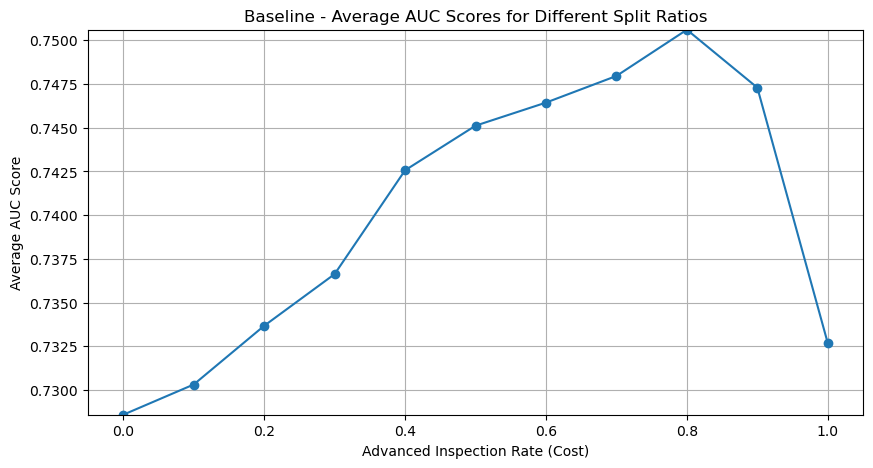

In [35]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader



# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_randomsampling import split_and_predict
from seed_everything import seed_everything
from train_teacher import train_teacher
from train_kdstudent import train_kdstudent
from train_student import train_student
from test_predict import test_predict


#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#


# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_KD_biased_margin_t10 = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

mat_file = io.loadmat('/home/iai/heo/recipe1/activeinspection_recipe1.mat')
X = mat_file['X']
X = X[:, 4:]
Y = mat_file['Y1']
Y = np.squeeze(Y)
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})


# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


### 클래스 weight 설정하기

a=87/(18384+87)
b=18384/(18384+87)
weights=[a,b]
weights=torch.FloatTensor(weights)



# loss function - crossentropy()함수

criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_KD_t10=[]
auc_score30_split_KD_0_2_t10=[]
auc_score30_split_ad_KD_t10=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=3694
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    
    # Teacher model (advanced model 구하기)    
    
    best_teacher_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/advance_model_recipe1/advancemodel_randomstate{}'.format(i))  

    best_student_model=torch.load('/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch/temperature10_kd_model_recipe1/temperature10_kd_basicmodel_randomstate{}'.format(i))
            
    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    test_data=pd.concat([test_X,test_y],axis=1)
    # 예측값을 numpy 배열로 변환    
   

# training 데이터에서 고장난 제품의 비율(Fault Ratio) 계산

    fr = np.sum(test_y) / len(test_y)

# Biased margin을 계산하여 uncertainty score로 사용

    def calculate_biased_margin(y_pred, fr):
        if y_pred <= fr:
            return y_pred / fr
        else:
            return (1 - y_pred) / (1 - fr)

# 각각의 예측에 대해 biased margin을 계산
    uncertainty_scores = [calculate_biased_margin(y_pred, fr.item()) for y_pred in y_predictions]
    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_KD_biased_margin_t10[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t10.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T=10일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t10.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t10.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_KD_biased_margin_t10 = auc_scores_KD_biased_margin_t10.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_biased_margin_t10, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_biased_margin_t10), max(average_auc_scores_KD_biased_margin_t10))
plt.grid()
plt.show()   

In [36]:
average_auc_scores_KD_biased_margin_t10

array([0.72858769, 0.73031576, 0.73367359, 0.73663124, 0.74256855,
       0.74511952, 0.74644009, 0.74796406, 0.7506084 , 0.74729467,
       0.73267684])

In [37]:
# T가 10일 때 KD 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_KD_t10)))

# KD 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_KD_t10)))

0.7285876882401034
0.06613142459493683


### Biased_Margin - VM

/home/iai/heo/recipe1_total_25_new/pytorch_module
Random state가  1 일 때 , VM model:  0.7715231624337369
Random state가  1 일 때 , Advance model:  0.7387797689690642
Random state가  2 일 때 , VM model:  0.7617196771896511
Random state가  2 일 때 , Advance model:  0.790022450352085
Random state가  3 일 때 , VM model:  0.7414896352559538
Random state가  3 일 때 , Advance model:  0.756502690086241
Random state가  4 일 때 , VM model:  0.6366207769602025
Random state가  4 일 때 , Advance model:  0.6358518276762403
Random state가  5 일 때 , VM model:  0.7146085528918427
Random state가  5 일 때 , Advance model:  0.6935452765250416
Random state가  6 일 때 , VM model:  0.7579614684706069
Random state가  6 일 때 , Advance model:  0.7603424914945803
Random state가  7 일 때 , VM model:  0.7638831197088376
Random state가  7 일 때 , Advance model:  0.7319346368383575
Random state가  8 일 때 , VM model:  0.7785599137589999
Random state가  8 일 때 , Advance model:  0.6969029393148192
Random state가  9 일 때 , VM model:  0.7702127343935438
Random stat

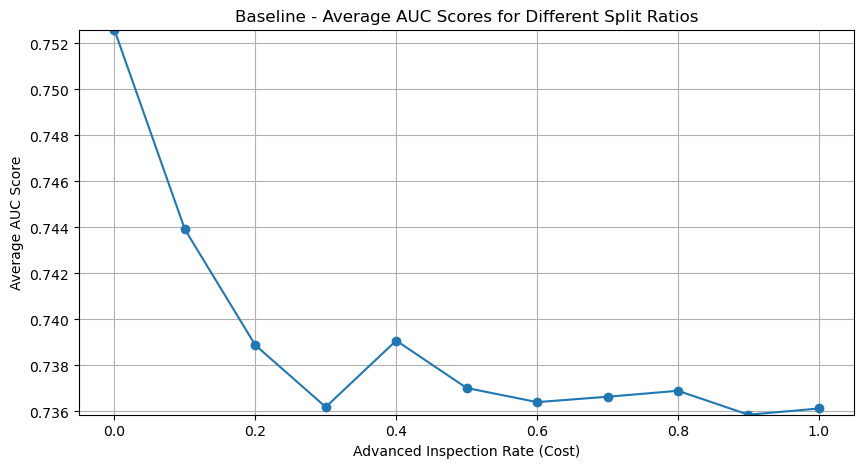

In [29]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader

# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_randomsampling import split_and_predict
from seed_everything import seed_everything
from train_teacher import train_teacher
from train_kdstudent import train_kdstudent
from train_student import train_student
from test_predict import test_predict

#---------------------------------------------------------------------------------------------------------------------------------------------------------------

# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의
split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# 데이터 업로드

mat_file = io.loadmat('/home/iai/heo/recipe1/activeinspection_recipe1.mat')
X = mat_file['X']
X = X[:, 4:]
Y = mat_file['Y1']
Y = np.squeeze(Y)
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})

# 난수 고정

seed_everything(42)

# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200

auc_score30_split_VM=[]
auc_score30_split_VM_0_2=[]
auc_score30_split_ad_VM=[]

random_states=range(1, 31)
auc_scores_VM_biased_margin= np.zeros((len(random_states), len(split_ratios)))
# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X2, val_X, train_y2, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X2)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y2),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
     
    batch_size=3694
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)

    best_teacher_model=torch.load('/home/iai/heo/recipe1_total_25_new/pytorch/advance_model_recipe1/advancemodel_randomstate{}'.format(i))    
    
    # 가상계측 변수 만들기

    test_X_new=pd.read_csv('/home/iai/heo/recipe1_total_25_new/pytorch/vm_dataset/virtual_dataset_randomstate{}.csv'.format(i))

    # 가상계측 변수 Scaling해주기   

    test_X_new_scaled=scaler.transform(test_X_new)
    
    # 가상계측 변수가 포함된 VM model로 test data 예측하기

    test_X_new_tensor=torch.tensor(test_X_new_scaled,dtype=torch.float32)
    test_new_tensorboard=TensorDataset(test_X_new_tensor,test_y_tensor)
    test_new_loader=DataLoader(test_new_tensorboard,batch_size=batch_size,shuffle=False)  
    y_predictions=test_predict(best_teacher_model,"best_teacher_model",test_new_loader)

    test_data=pd.concat([test_X,test_y],axis=1)

# training 데이터에서 고장난 제품의 비율(Fault Ratio) 계산

    fr = np.sum(test_y) / len(test_y)

# Biased margin을 계산하여 uncertainty score로 사용
    def calculate_biased_margin(y_pred, fr):
        if y_pred <= fr:
            return y_pred / fr
        else:
            return (1 - y_pred) / (1 - fr)

# 각각의 예측에 대해 biased margin을 계산
    uncertainty_scores = [calculate_biased_margin(y_pred, fr.item()) for y_pred in y_predictions]
    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']     
    # Loop through the split_ratios
    for j, split_ratio in enumerate(split_ratios):
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        auc_scores_VM_biased_margin[i, j] = auc_score
        if split_ratio==0:
            auc_score30_split_VM.append(auc_score)
            print('Random state가 ',i+1,'일 때 , VM model: ',auc_score)
        if split_ratio==1:
            auc_score30_split_ad_VM.append(auc_score)
            print('Random state가 ',i+1,'일 때 , Advance model: ',auc_score)    
    
# Calculate the average AUC scores

average_auc_scores_VM_biased_margin = auc_scores_VM_biased_margin.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_VM_biased_margin, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_VM_biased_margin), max(average_auc_scores_VM_biased_margin))
plt.grid()
plt.show()    

In [22]:
average_auc_scores_VM_biased_margin

array([0.75259543, 0.74391891, 0.73888234, 0.73619118, 0.73907878,
       0.73701893, 0.73640386, 0.73663734, 0.73689691, 0.73585578,
       0.73612661])

In [23]:
#VM 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_VM)))

# VM 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_VM)))

0.752595430479732
0.03801917945527837


In [26]:
data=pd.DataFrame()
data['split_ratios']=np.array(split_ratios)
data['Baseline']=np.array(average_auc_scores_Baseline_biased_margin)
data['t1_kd']=np.array(average_auc_scores_KD_biased_margin_t1)
data['t2_kd']=np.array(average_auc_scores_KD_biased_margin_t2)
data['t5_kd']=np.array(average_auc_scores_KD_biased_margin_t5)
data['t10_kd']=np.array(average_auc_scores_KD_biased_margin_t10)
data['vm']=np.array(average_auc_scores_VM_biased_margin)
data.head(5)

,split_ratios,Baseline,t1_kd,t2_kd,t5_kd,t10_kd,vm
0,0.0,0.704095,0.691137,0.733133,0.731317,0.726004,0.752595
1,0.1,0.705559,0.687110,0.728285,0.730602,0.724389,0.743919
2,0.2,0.698677,0.691818,0.727419,0.726176,0.722623,0.738882
3,0.3,0.702891,0.696659,0.728399,0.727174,0.722598,0.736191
4,0.4,0.709801,0.703483,0.729017,0.731219,0.723092,0.739079


In [39]:
average_auc_scores_Baseline_biased_margin=[0.70972012, 0.71428078, 0.71741786, 0.7176218 , 0.7270835 , 0.72990965, 0.73262228, 0.73842538, 0.74312709, 0.74485138, 0.732677]
average_auc_scores_KD_biased_margin_t1=[0.72645548, 0.73091996, 0.73298108, 0.73463329, 0.7376793 , 0.74169683, 0.7445281 , 0.74669735, 0.74664164, 0.74723689, 0.732677]
average_auc_scores_KD_biased_margin_t2=[0.73459398, 0.73501113, 0.73995285, 0.74052148, 0.74544989, 0.74802455, 0.74925079, 0.75115684, 0.74963106, 0.74703852, 0.732677]
average_auc_scores_KD_biased_margin_t5=[0.72254765, 0.72544843, 0.72806859, 0.73045876, 0.73525546, 0.73965149, 0.74515282, 0.74670048, 0.74700839, 0.74647684, 0.732677]
average_auc_scores_KD_biased_margin_t10=[0.72858769, 0.73031576, 0.73367359, 0.73663124, 0.74256855, 0.74511952, 0.74644009, 0.74796406, 0.7506084 , 0.74729467, 0.732677]

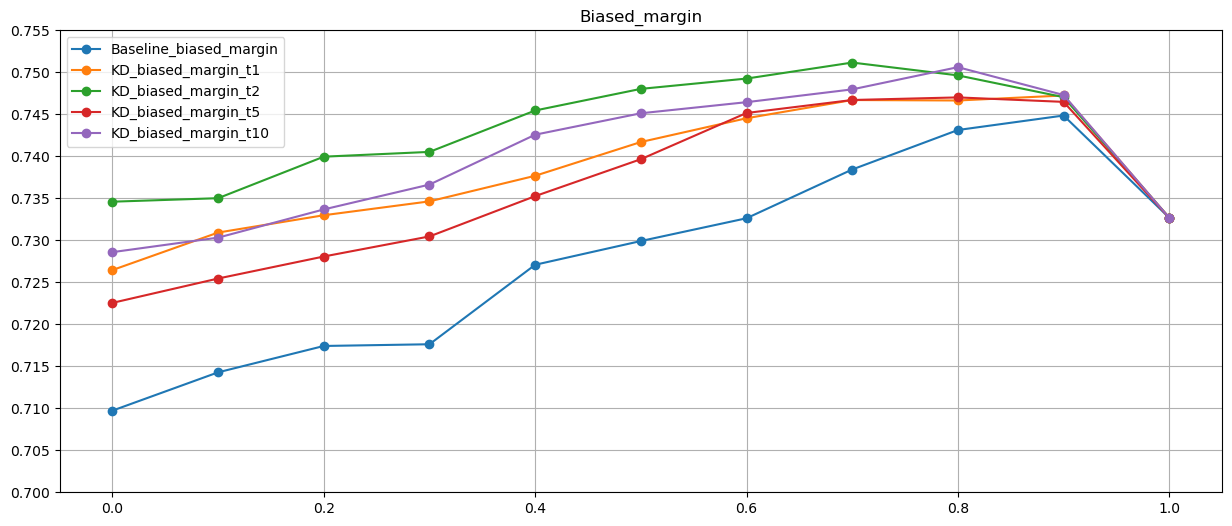

In [40]:
import matplotlib.pyplot as plt 

split_ratio=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

plt.figure(figsize=(15,6))
plt.plot(split_ratio,average_auc_scores_Baseline_biased_margin,marker='o',label='Baseline_biased_margin')
plt.plot(split_ratio,average_auc_scores_KD_biased_margin_t1,marker='o',label='KD_biased_margin_t1')
plt.plot(split_ratio,average_auc_scores_KD_biased_margin_t2,marker='o',label='KD_biased_margin_t2')
plt.plot(split_ratio,average_auc_scores_KD_biased_margin_t5,marker='o',label='KD_biased_margin_t5')
plt.plot(split_ratio,average_auc_scores_KD_biased_margin_t10,marker='o',label='KD_biased_margin_t10')
#plt.plot(split_ratio,average_auc_scores_VM_biased_margin,marker='o',label='VM_biased_margin')
plt.legend()
plt.title('Biased_margin')
plt.yticks([0.70,0.705,0.71,0.715,0.72,0.725,0.730,0.735,0.74,0.745,0.75,0.755])
plt.grid()
plt.show()